In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize(data, y, x, hues, chart):
    plt.figure(figsize=(12,8))
    match chart:
        case 'line':
            chart_type = sns.lineplot
        case 'bar':
            chart_type = sns.barplot
        case 'box':
            chart_type = sns.boxplot
    try:
        if len(hues) > 1:
            data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)
        else:
            data['hues'] = data[hues[0]]

        chart_type(data=data,x = x, y = y, hue='hues', palette='viridis')

        plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}')
        plt.show()
    except (KeyError, ValueError) as e:
        print(f"You've passed an incorrect column name.\n The correct ones are: \n{data.columns}\nException: {e}")
    


In [12]:
data_missing = pd.read_csv("results_papergraph_p_10_vanilla_param_initialization_{'gaussian', 'static'}_warm_start_{False, True} - results_papergraph_param_initialization_{'gaussian', 'static'}_warm_start_{False, True}.csv")
# Create a new column combining graph_name, warm_start and param_initialization
data_missing['combined'] = data_missing['graph_name'] + '_' + data_missing['warm_start'].astype(str) + '_' + data_missing['param_initialization']

# Count instances of each combination
combination_counts = data_missing['combined'].value_counts()

# Print the number of instances for each combination
print("Number of instances for each combination:")
print(combination_counts)

# Summary statistics
print("\nTotal number of instances:", len(data_missing))
print("Number of unique combinations:", len(combination_counts))


Number of instances for each combination:
combined
>>graph6<<DkO_False_gaussian        48
>>graph6<<Dm{_False_gaussian        48
>>graph6<<FkPsg_False_gaussian      48
>>graph6<<Fm~]w_False_gaussian      48
>>graph6<<HkPsgZ@_False_gaussian    48
>>graph6<<DkO_True_gaussian         48
>>graph6<<Dm{_True_gaussian         48
>>graph6<<FkPsg_True_gaussian       48
>>graph6<<FkPsg_False_static        48
>>graph6<<Fm~]w_True_gaussian       48
>>graph6<<HkPsgZ@_True_gaussian     48
>>graph6<<DkO_False_static          48
>>graph6<<Fm~]w_False_static        48
>>graph6<<Dm{_False_static          48
>>graph6<<HkPsgZ@_False_static      48
>>graph6<<Hm~]x^^_True_gaussian     47
>>graph6<<FkPsg_True_static         47
>>graph6<<Hm~]x^^_False_static      47
>>graph6<<DkO_True_static           47
>>graph6<<Dm{_True_static           47
>>graph6<<HkPsgZ@_True_static       47
>>graph6<<Fm~]w_True_static         47
>>graph6<<Hm~]x^^_False_gaussian    46
>>graph6<<Hm~]x^^_True_static       45
Name: count, 

### Configure the results you want to visualize under.



In [2]:
import ast
import numpy as np


"""strings = ["results/results_papergraph_depth_{2, 10}_vertexcover_50RI.csv",
           "results/results_papergraph_depth_{2, 10}MaxCut_50RI.csv",
           "results/results_papergraph_depth_{2, 4, 6, 8, 10}.csv",
           "results/results_papergraph_depth_{2, 10}.csv"]"""
strings = [
    "results/results_papergraph_depth_{1, 2, 4}_warm_start_{False, True}.csv",
    "results/results_papergraph_param_initialization_{'gaussian', 'static'}_depth_{1, 2, 10, 4}_warm_start_{False, True}.csv",
    "results/results_papergraph_param_initialization_{'gaussian', 'static'}_depth_{1, 2, 4}_warm_start_{False, True}.csv",
    "results/results_papergraph_param_initialization_{'static', 'gaussian'}_depth_{1, 2, 4}_warm_start_{False, True}.csv",
    "results/results_papergraph_param_initialization_{'static', 'gaussian'}_warm_start_{False, True}.csv"
]



for file in strings:
    try:
        df = pd.read_csv(file)
        print(f"File: {file}")
        print(df['graph_name'].value_counts())
        print("\n")
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings) >1:
    results = pd.concat([pd.read_csv(path,index_col=0) for path in strings])

else:
    results = pd.read_csv(strings[0])

#results['classic_value'] = results['classic_solution'].apply(lambda x: np.sum(ast.literal_eval(x)))
results['ratio'] = results['quantum_obj_value']/results['classic_value']
#results = results[~results['depth'].isin([4, 6, 8])]
#results.drop('Unnamed: 0', axis=1, inplace=True)

#rint(results.head())
print(results.head())



File: results/results_papergraph_depth_{1, 2, 4}_warm_start_{False, True}.csv
graph_name
>>graph6<<DkO        300
>>graph6<<Dm{        300
>>graph6<<FkPsg      300
>>graph6<<Fm~]w      300
>>graph6<<HkPsgZ@    300
>>graph6<<Hm~]x^^    300
Name: count, dtype: int64


File: results/results_papergraph_param_initialization_{'gaussian', 'static'}_depth_{1, 2, 10, 4}_warm_start_{False, True}.csv
graph_name
>>graph6<<DkO        800
>>graph6<<Dm{        800
>>graph6<<FkPsg      800
>>graph6<<HkPsgZ@    800
>>graph6<<Fm~]w      800
>>graph6<<Hm~]x^^    800
Name: count, dtype: int64


File: results/results_papergraph_param_initialization_{'gaussian', 'static'}_depth_{1, 2, 4}_warm_start_{False, True}.csv
graph_name
>>graph6<<DkO        600
>>graph6<<Dm{        600
>>graph6<<FkPsg      600
>>graph6<<Fm~]w      600
>>graph6<<HkPsgZ@    600
>>graph6<<Hm~]x^^    600
Name: count, dtype: int64


File: results/results_papergraph_param_initialization_{'static', 'gaussian'}_depth_{1, 2, 4}_warm_start_{Fa

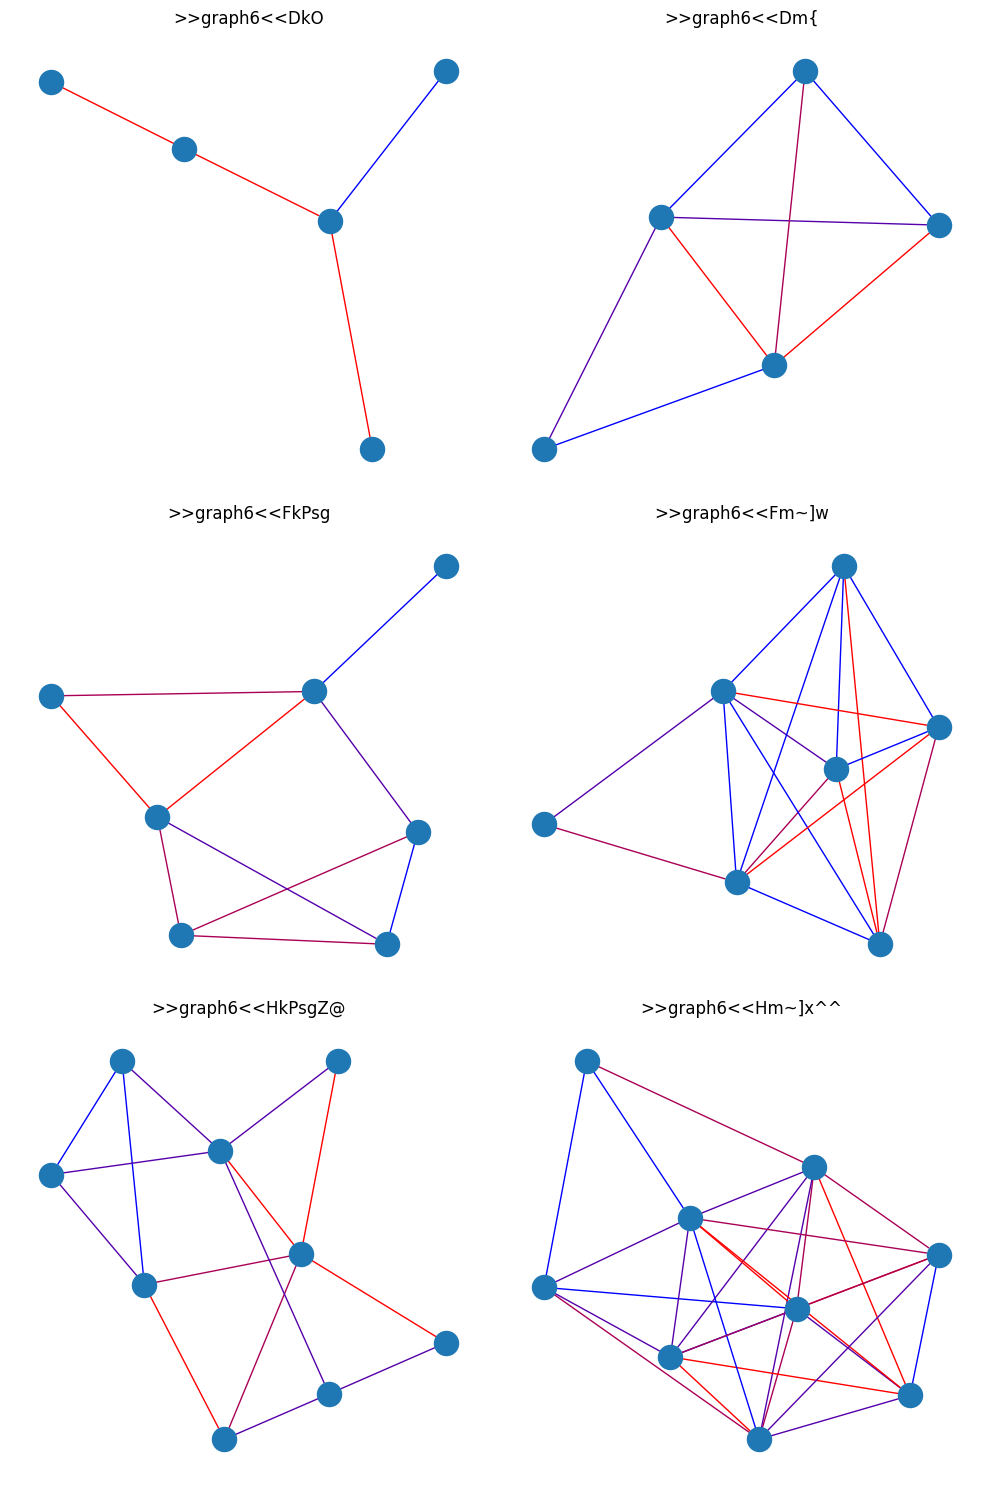

In [45]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
import networkx as nx
from rustworkx.visualization import mpl_draw as draw_graph_func
from MaxCutProblem import MaxCutProblem

# set up problem and graphs
problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs([5, 7, 9])

# create a simple blue→red colormap
cmap = LinearSegmentedColormap.from_list("blue_red", ["blue", "red"])

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
axs = axs.flatten()

for i, g in enumerate(graphs):
    ax = axs[i]

    # get (u, v, weight) triples
    weighted_edges = g.weighted_edge_list()
    weights = [w for _, _, w in weighted_edges]

    # normalize weights to [0,1]
    norm = Normalize(vmin=min(weights), vmax=max(weights))

    # map each weight to an RGB(A) from blue→red
    edge_colors = [cmap(norm(w)) for _, _, w in weighted_edges]

    # draw with the per-edge colours
    draw_graph_func(
        g,
        ax=ax,
        with_labels=False,
        edge_color=edge_colors,
    )

    # title with graph6 string
    graph = nx.Graph(list(g.edge_list()))
    graph6_string = nx.to_graph6_bytes(graph).decode("utf-8").strip()
    ax.set_title(graph6_string)
    ax.axis("off")

plt.tight_layout()
plt.show()


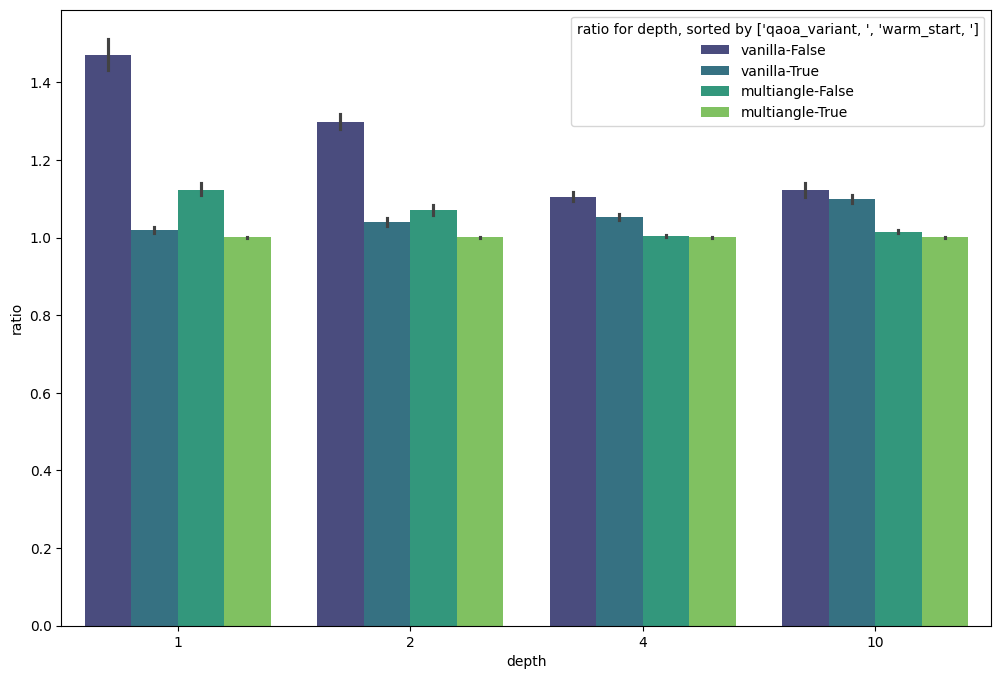

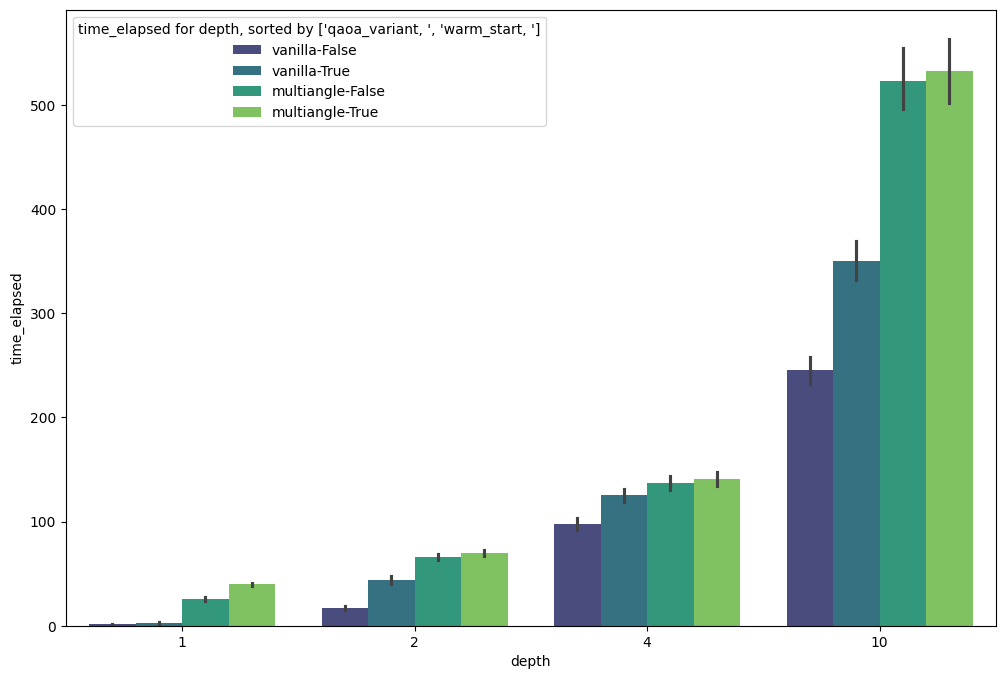

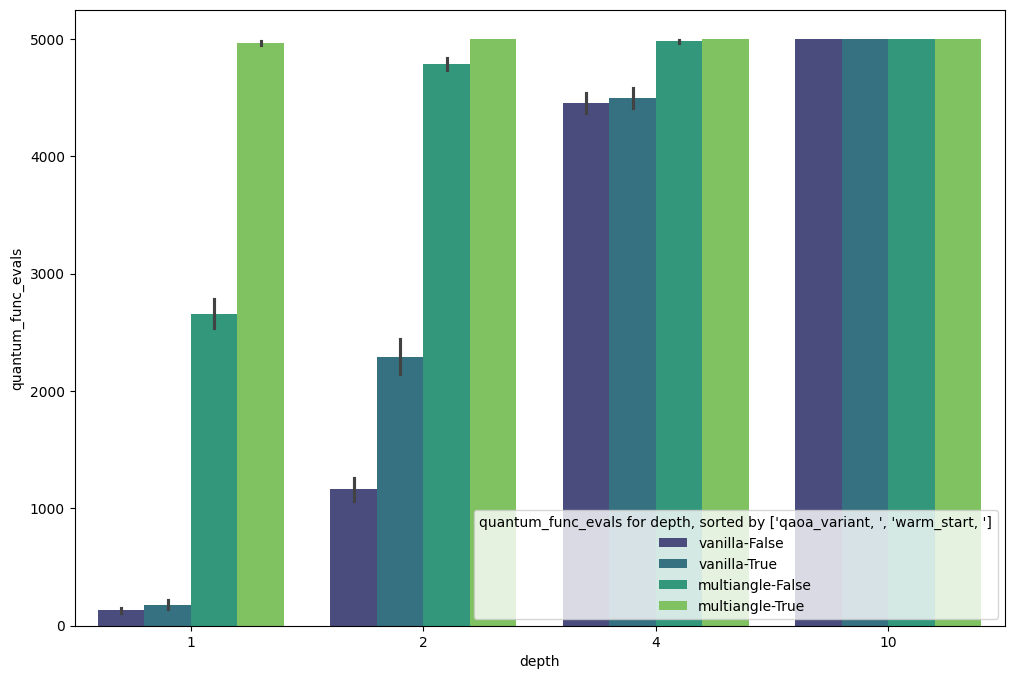

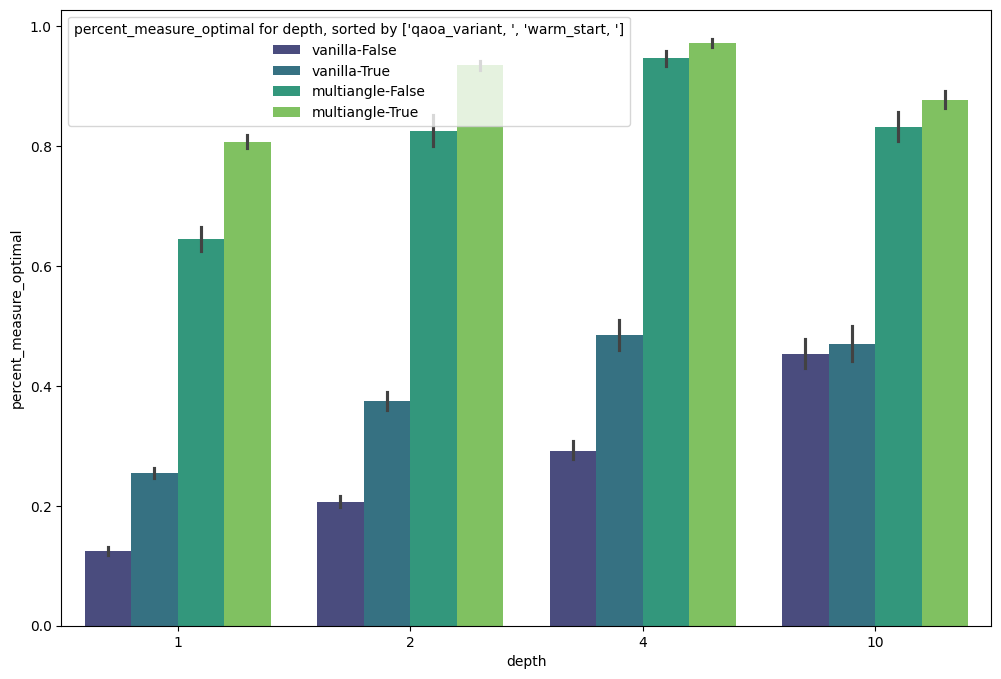

<Figure size 640x480 with 0 Axes>

In [13]:
results = results[results['backend_mode'] =='statevector']
y_values = ['ratio', 'time_elapsed', 'quantum_func_evals', 'percent_measure_optimal']
x = 'depth'
hues = ['qaoa_variant','warm_start']

for y in y_values:
    visualize(results, y, x, hues, 'bar')
plt.tight_layout()


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


Visualizing ratio for graph: >>graph6<<DbS


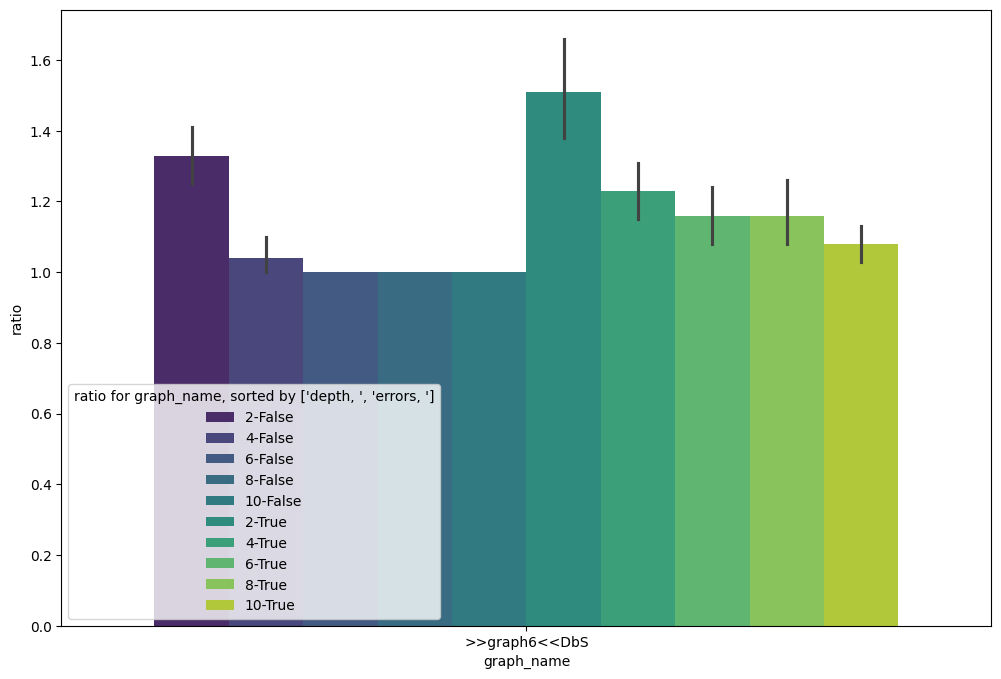

Visualizing time_elapsed for graph: >>graph6<<DbS


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


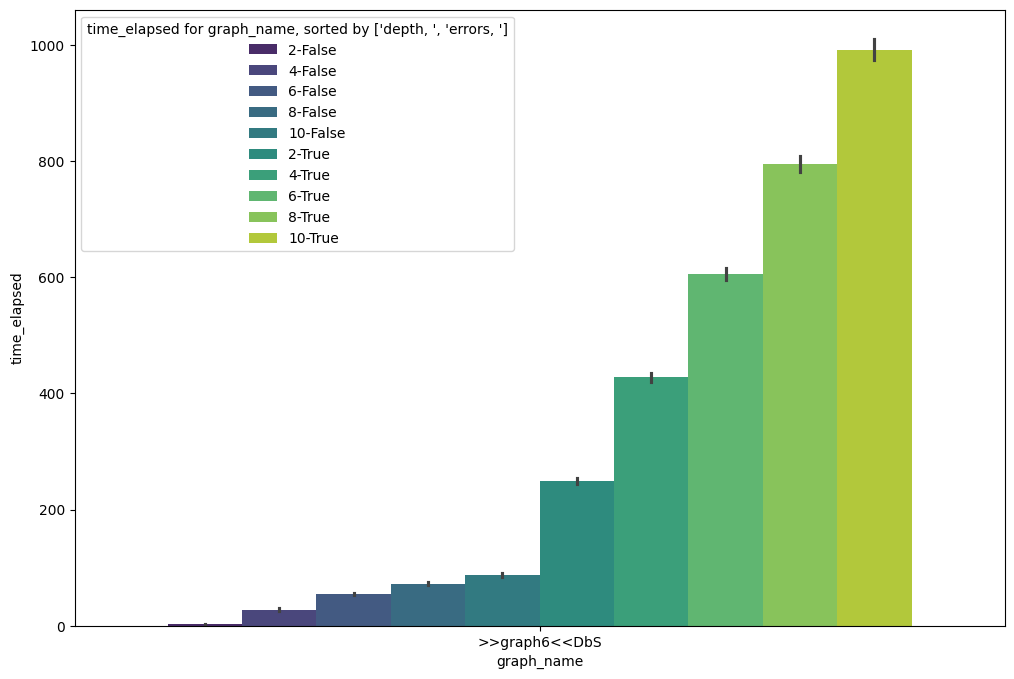

Visualizing quantum_func_evals for graph: >>graph6<<DbS


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


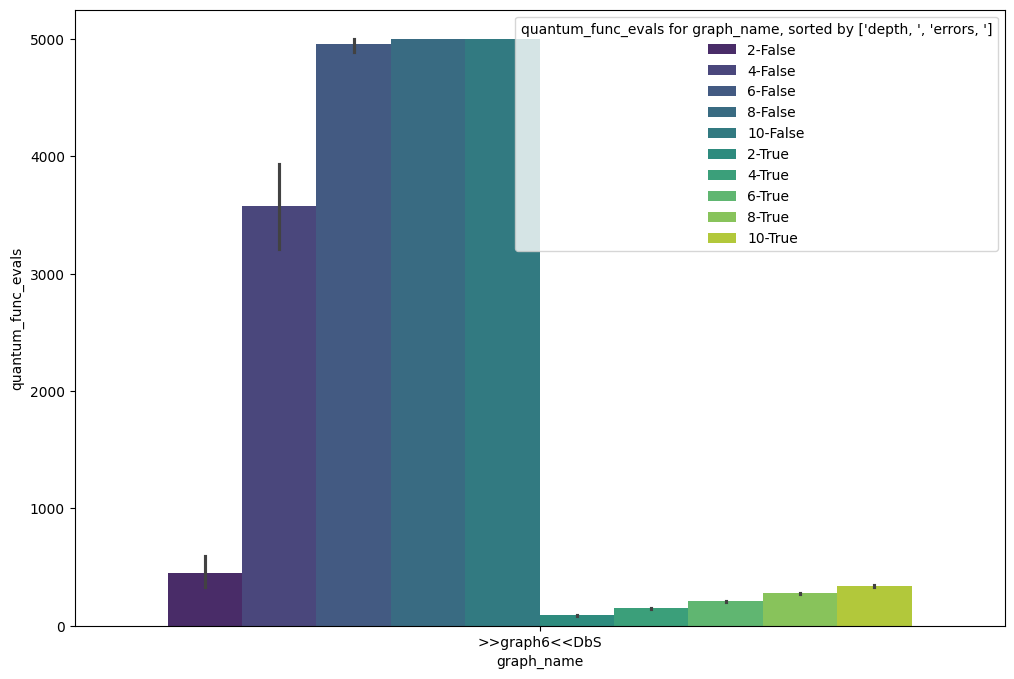

Visualizing percent_measure_optimal for graph: >>graph6<<DbS


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


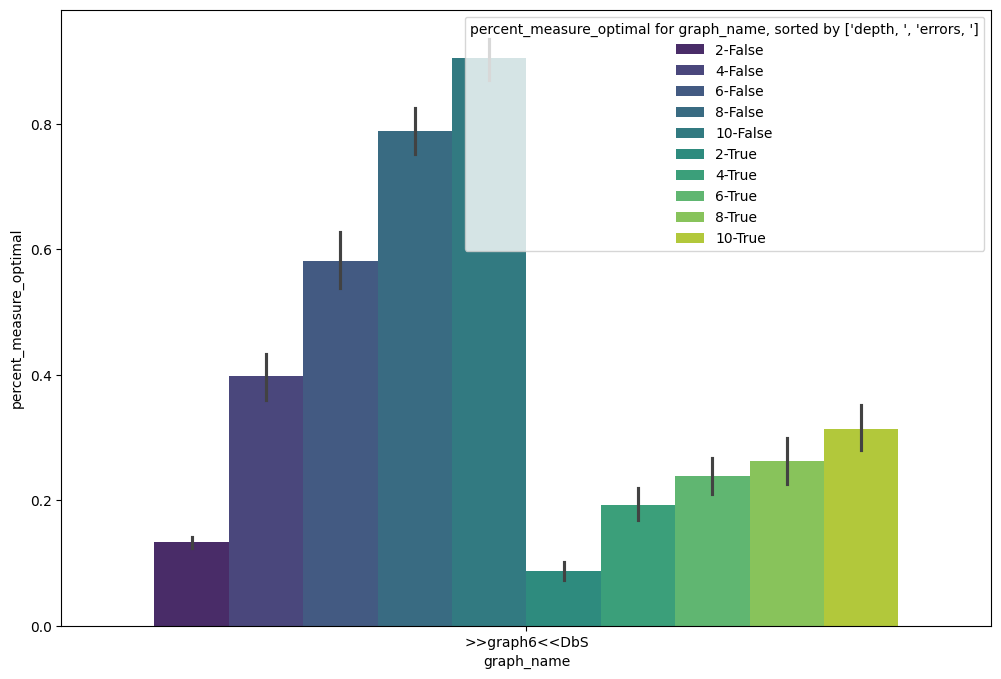

Visualizing ratio for graph: >>graph6<<DxK


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


<Figure size 640x480 with 0 Axes>

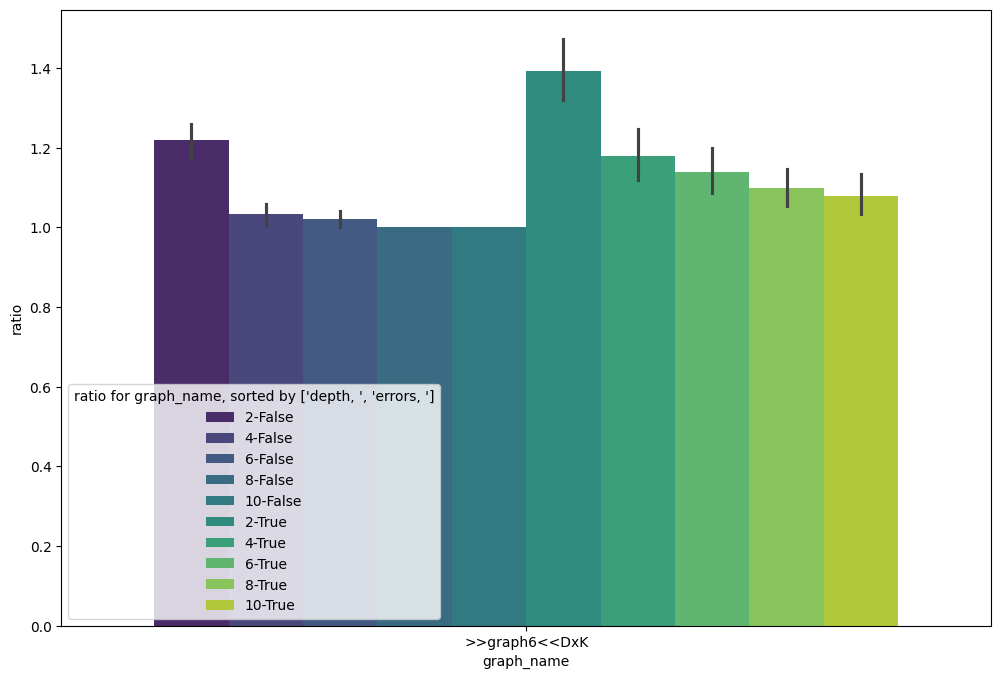

Visualizing time_elapsed for graph: >>graph6<<DxK


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


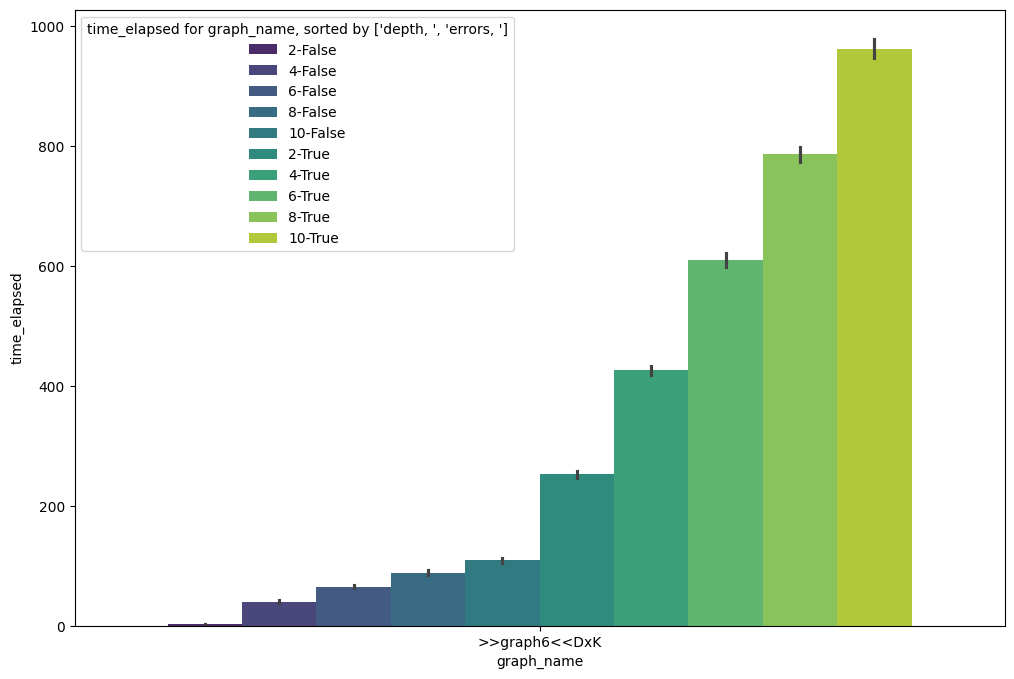

Visualizing quantum_func_evals for graph: >>graph6<<DxK


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


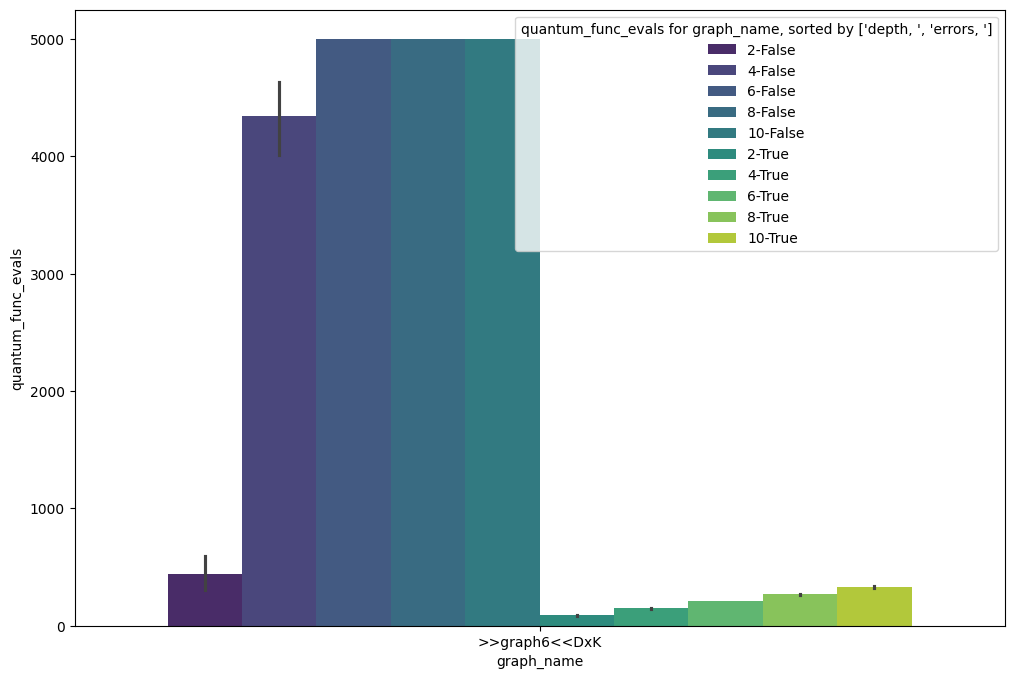

Visualizing percent_measure_optimal for graph: >>graph6<<DxK


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


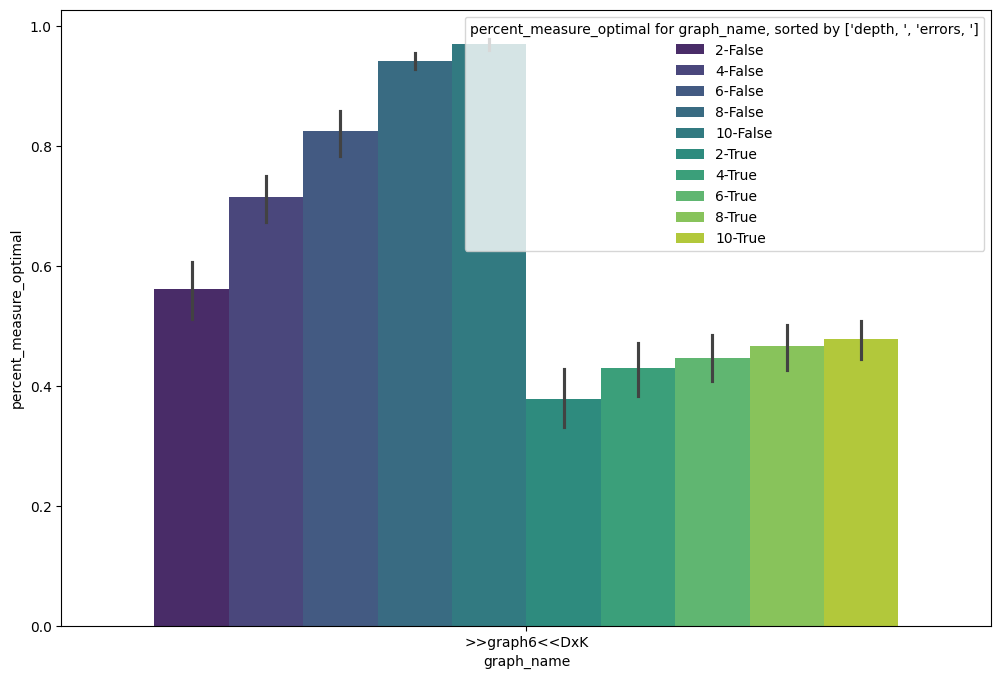

Visualizing ratio for graph: >>graph6<<Dv[


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


<Figure size 640x480 with 0 Axes>

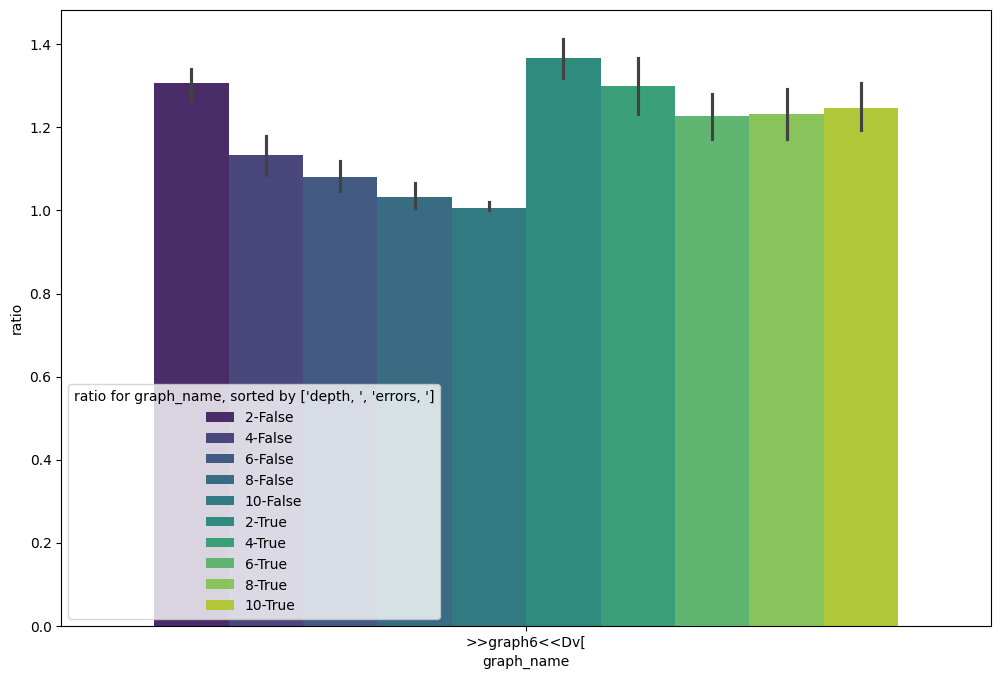

Visualizing time_elapsed for graph: >>graph6<<Dv[


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


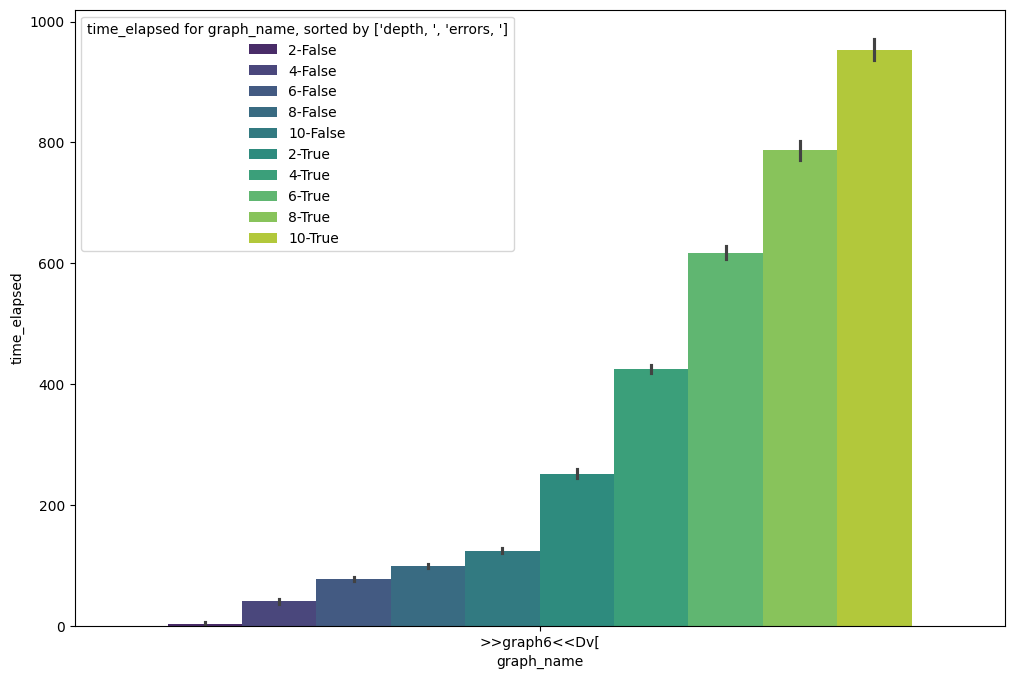

Visualizing quantum_func_evals for graph: >>graph6<<Dv[


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


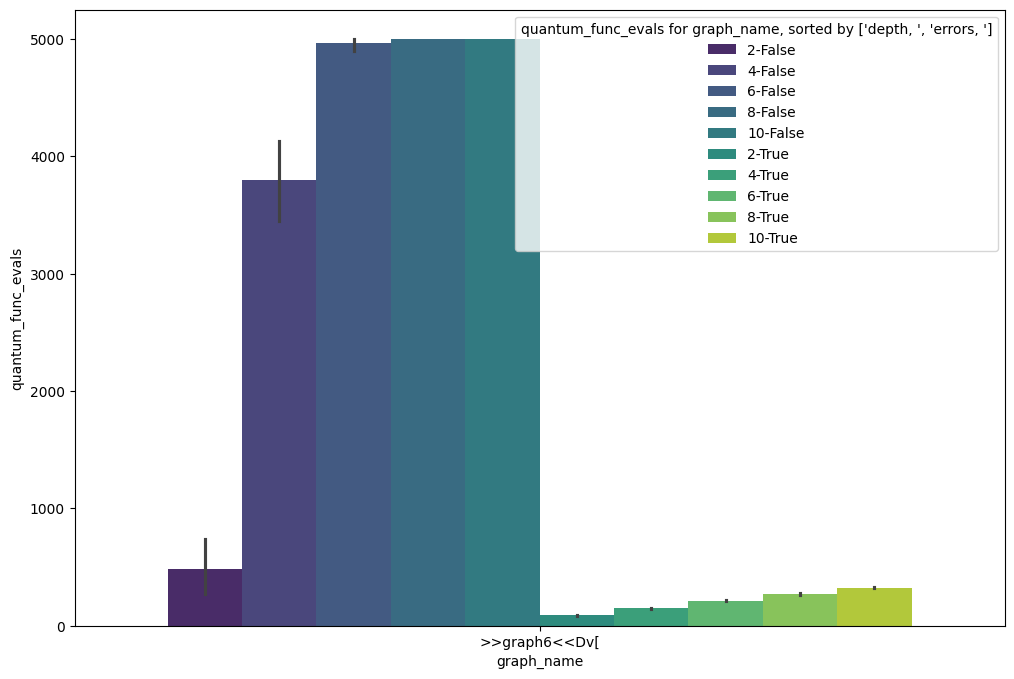

Visualizing percent_measure_optimal for graph: >>graph6<<Dv[


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_22436\3079784610.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)


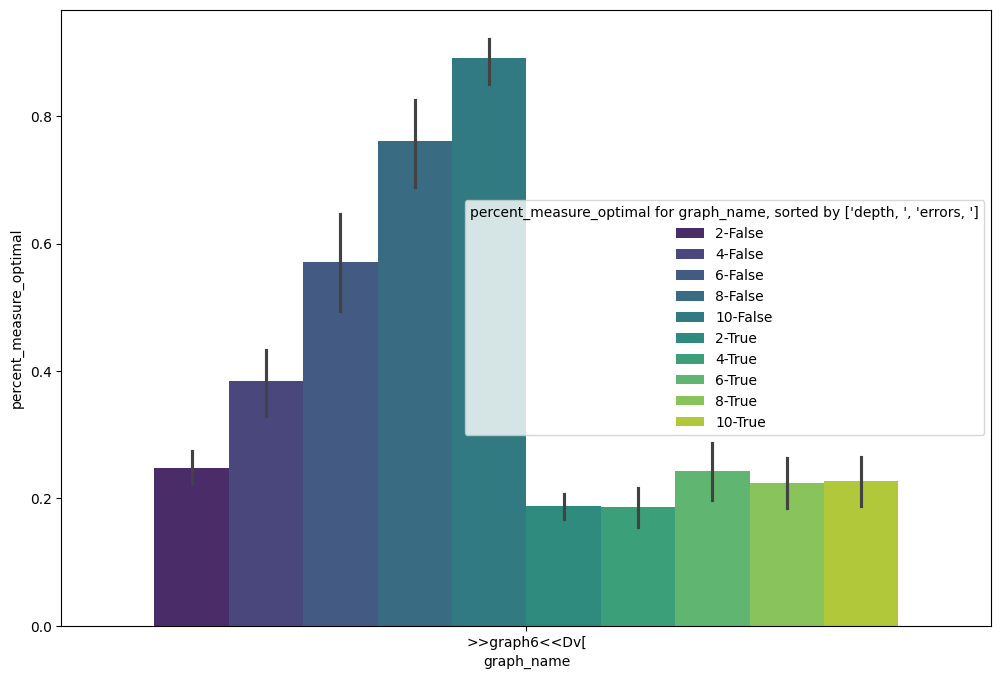

<Figure size 640x480 with 0 Axes>

In [5]:
results_maxcut = results[results['vertexcover'] == True]

y_values = ['ratio', 'time_elapsed', 'quantum_func_evals', 'percent_measure_optimal']
x = 'graph_name'
hues = ['depth', 'errors']

for graph_name in results_maxcut['graph_name'].unique():
    filtered_data = results_maxcut[results_maxcut['graph_name'] == graph_name]
    for y in y_values:
        print(f"Visualizing {y} for graph: {graph_name}")
        visualize(filtered_data, y, x, hues, 'bar')
    plt.tight_layout()


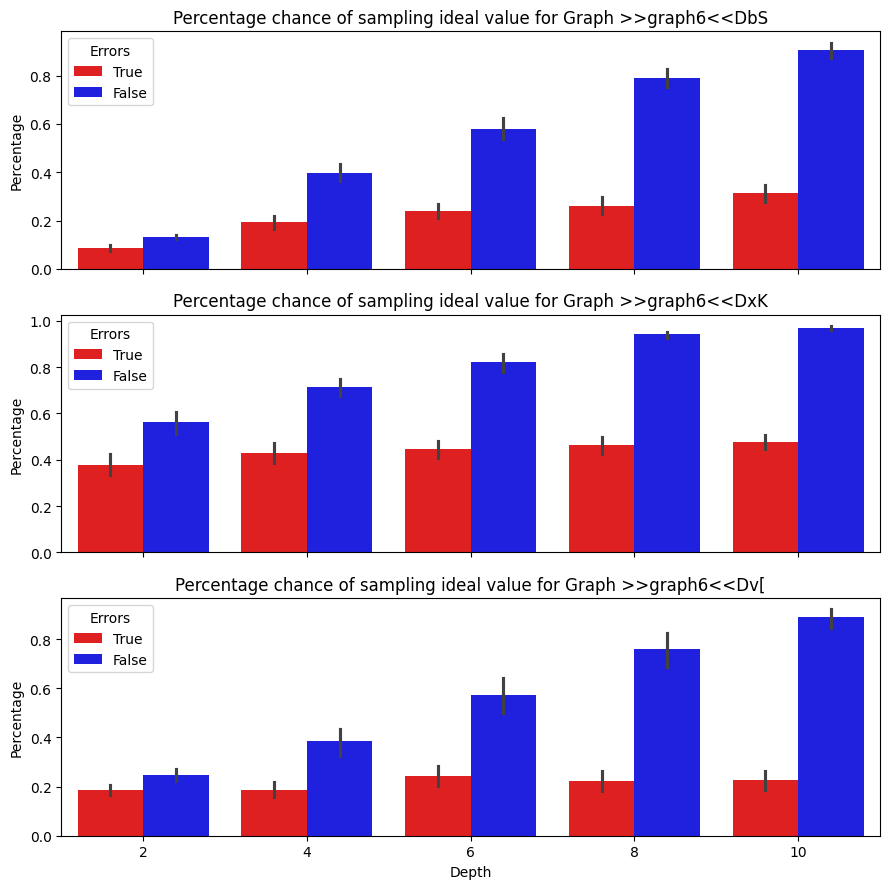

In [16]:
graph_names = results['graph_name'].unique()

fig, axes = plt.subplots(len(graph_names), 1, figsize=(9, 3 * len(graph_names)), sharex=True)

for i, graph_name in enumerate(graph_names):
    ax = axes[i] if len(graph_names) > 1 else axes
    sns.barplot(
        data=results[results['graph_name'] == graph_name],
        x='depth',
        y='percent_measure_optimal',
        hue='errors',
        hue_order=[True, False],  # Switch the order of errors
        palette=['red', 'blue'],  # Adjust colors to match the new order
        ax=ax
    )
    ax.set_xlabel('Depth')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Percentage chance of sampling ideal value for Graph {graph_name}')
    ax.legend(title='Errors')

plt.tight_layout()
plt.show()

Found 32 CSV files in results folder
Error processing results\results_gaussian_COBYLA_vanilla_False_False_1000_100_500.csv: ['final_params']
Error processing results\results_gaussian_COBYLA_vanilla_False_False_200.csv: ['final_params']
Error processing results\results_gaussian_COBYLA_vanilla_False_False_300.csv: ['final_params']
Error processing results\results_gaussian_COBYLA_vanilla_False_False_400.csv: ['final_params']
Error processing results\results_gaussian_COBYLA_vanilla_False_False_500.csv: ['final_params']
Error processing results\results_gaussian_COBYLA_vanilla_False_False_600.csv: ['final_params']
Error processing results\results_gaussian_COBYLA_vanilla_False_False_True_2_4_6_8_10.csv: ['final_params']
Error processing results\results_gaussian_L-BFGS-B_vanilla_False_False_600.csv: ['final_params']
Skipping results\results_underway.csv
len results 25704
len results after filtering vanilla 23826
len results after filtering 4492


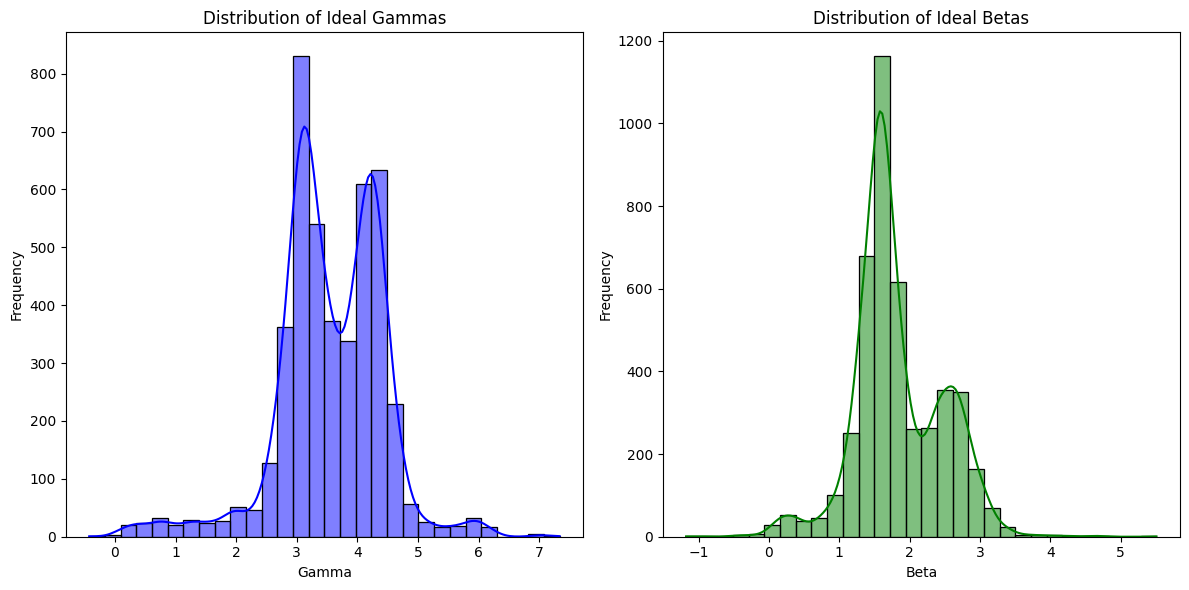

In [32]:
import os
import glob

# List of CSV files containing results for depth 1

# Read all files in the results list
dataframes = []
# Get all CSV files in the results folder
results_folder = 'results'
csv_files = glob.glob(f'{results_folder}/*.csv')
print(f"Found {len(csv_files)} CSV files in {results_folder} folder")

for file in csv_files:
    # Skip the 'results_underway.csv' file
    if 'results_underway.csv' in file:
        print(f"Skipping {file}")
        continue
        
    try:
        df = pd.read_csv(file)
        initial_count = len(df)
        
        # Remove rows with NaN values in 'final_params'
        df = df.dropna(subset=['final_params'])
        removed_count = initial_count - len(df)
        #print(f"Processed {file}: {initial_count} rows, removed {removed_count} rows with NaN 'final_params'")
        
        # Drop 'obj_func_evolution' column if it exists
        if 'obj_func_evolution' in df.columns:
            df = df.drop(columns=['obj_func_evolution'])
        
        dataframes.append(df)
    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")

# Combine all dataframes into a single dataframe
combined_results = pd.concat(dataframes, ignore_index=True)

print('len results', len(combined_results))

# Read and concatenate the CSV files into a single DataFrame
depth1_results = combined_results
#filter for depth 1
depth1_results = depth1_results[depth1_results['qaoa_variant']=='vanilla']
print('len results after filtering vanilla', len(depth1_results))
depth1_results = depth1_results[depth1_results['quantum_obj_value']==depth1_results['classic_value']]
print('len results after filtering', len(depth1_results))
# Replace spaces with commas in the 'final_params' column before evaluation
depth1_results['final_params'] = depth1_results['final_params'].str.replace(r'\s+', ',', regex=True)
depth1_results['final_params'] = depth1_results['final_params'].str.replace(r'\[,', '[', regex=True)
# Extract the ideal parameters
ideal_params = depth1_results['final_params'].apply(ast.literal_eval)

ideal_gammas = ideal_params.apply(lambda params: params[0] if isinstance(params, list) and len(params) > 0 else None)
ideal_betas = ideal_params.apply(lambda params: params[1] if isinstance(params, list) and len(params) > 0 else None)
# Model distributions (example: calculate mean and standard deviation for each parameter)
plt.figure(figsize=(12, 6))

# Plot distribution of ideal_gammas
plt.subplot(1, 2, 1)
sns.histplot(ideal_gammas, kde=True, bins=30, color='blue')
plt.title('Distribution of Ideal Gammas')
plt.xlabel('Gamma')
plt.ylabel('Frequency')

# Plot distribution of ideal_betas
plt.subplot(1, 2, 2)
sns.histplot(ideal_betas, kde=True, bins=30, color='green')
plt.title('Distribution of Ideal Betas')
plt.xlabel('Beta')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()